In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':14})
from scipy.integrate import odeint
import pickle

In [4]:
def toggle_switch(y,t): # two state system, with no inputs

    a1 = 0.5;
    a2 = 0.5;
    d1 = 0.5;
    d2 = 0.5;
    n1 = 4; 
    n2 = 2; 
    K1 = 1;
    K2 = 1;

    dy0 = a1/(K1+y[1]**n2) - d1*y[0] 
    dy1 = a1/(K2+y[0]**n1) - d2*y[1]
    
    return[dy0,dy1]

def slow_manifold(y,t): # two state system, with no inputs

    mu = -0.1
    lam = -0.2

    dy0 = mu*y[0]
    dy1 = lam*(y[1] - y[0]**2)
    
    return[dy0,dy1]

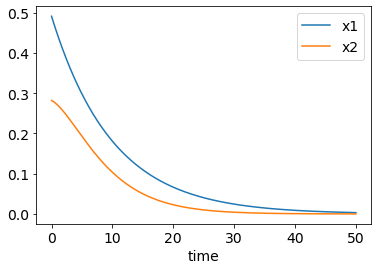

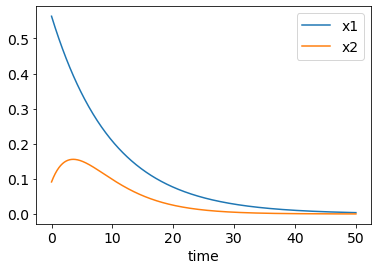

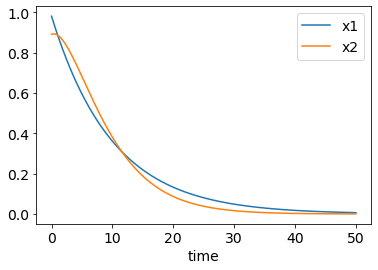

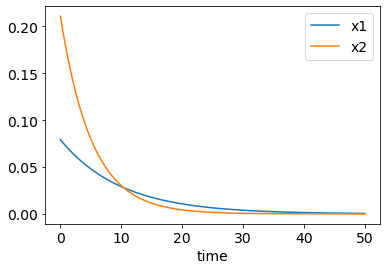

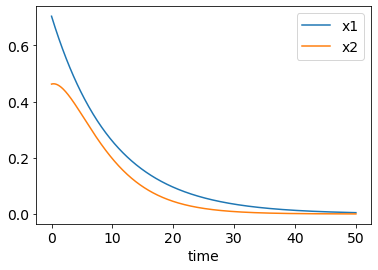

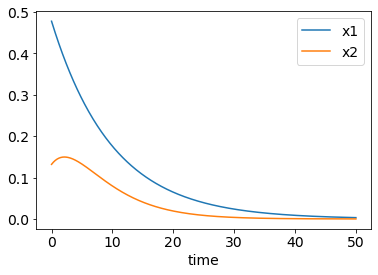

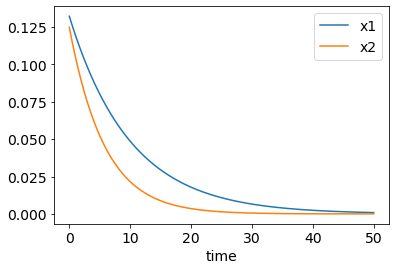

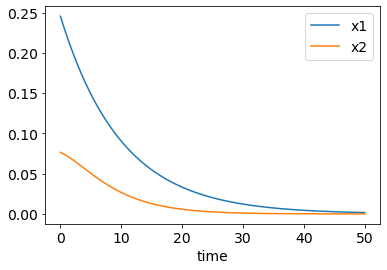

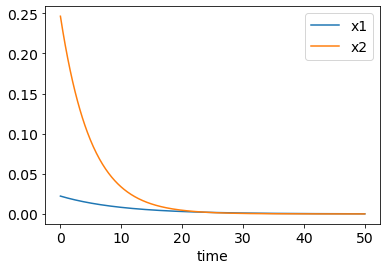

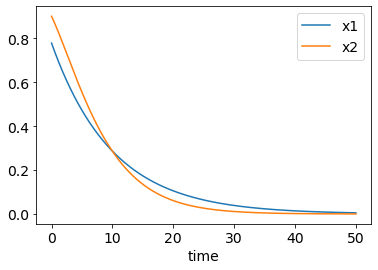

In [9]:
KG = True
# sysName = 'toggle_switch_KG.p' 
sysName = 'slow_manifold_KG.p'

numStates = 2

tStart = 0.0
tEnd = 50
dt = 0.1
numTimepoints = int(round((tEnd-tStart)/dt))
tSpan = np.linspace(tStart,tEnd,numTimepoints)

numTrajectories = 400 # pick a number divisible by 2 for splitting into train and test sets

data = np.zeros(shape=[numStates,numTimepoints,numTrajectories])
for traj in range(0,numTrajectories):
    x0 = np.random.uniform(0.01,1,numStates)
    x = odeint(slow_manifold,x0,tSpan)
    x = x.T[:,:,np.newaxis]
    data[:,:,traj:traj+1] = x
    
    if traj < 10:
        plt.figure();
        h = plt.plot(tSpan,data[:,:,traj].T);
        plt.legend((h[0],h[1]),('x1','x2'),loc='best');
        plt.xlabel('time');

In [11]:
if KG:
    nSamples = 250
    sel_inds = [] # indices we will randomly select
    sel_inds.append(0)
    while len(sel_inds) < (nSamples):
        r = np.random.randint(1,data.shape[1])
        if r not in sel_inds:
            sel_inds.append(r)
    sel_inds.sort() 

    # getting a list of ∆t's for KG learning. 
    sel_tSpan = tSpan[sel_inds]
    dt_list = []
    for i in range(0,len(sel_tSpan)-1):
        dt_list.append(sel_tSpan[i+1] - sel_tSpan[i])
    dt_list_final = []
    for i in range(0,numTrajectories):
        dt_list_final += dt_list

    data = data[:,sel_inds,:]

In [5]:
data = data.reshape(numStates,int(nSamples*numTrajectories),order='F')
data_normed = (data - data.mean(axis=1).reshape(numStates,1))/data.std(axis=1).reshape(numStates,1)

In [8]:
import os
os.chdir('..') # only run this once
save_data_to = os.getcwd() + '/data/' + sysName
pickle.dump([data_normed,nSamples,numTrajectories,dt_list_final], open(save_data_to, 'wb'))